# Chapter 3 - Regression Models 
## Segment 3 - Logistic regression

In [44]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [46]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

## Logistic regression on the titanic dataset

In [47]:
address = 'C:/Users/Admin/Springboard ML/Ex_Files_Python_Data_Science_EssT_Pt2/Exercise Files/Data/titanic-training-data.csv'
titanic_training = pd.read_csv(address)
titanic_training.columns = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
print(titanic_training.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [48]:
print(titanic_training.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


##### VARIABLE DESCRIPTIONS

Survived - Survival (0 = No; 1 = Yes)<br>
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)<br>
Name - Name<br>
Sex - Sex<br>
Age - Age<br>
SibSp - Number of Siblings/Spouses Aboard<br>
Parch - Number of Parents/Children Aboard<br>
Ticket - Ticket Number<br>
Fare - Passenger Fare (British pound)<br>
Cabin - Cabin<br>
Embarked - Port of Embarkation (C = Cherbourg, France; Q = Queenstown, UK; S = Southampton - Cobh, Ireland)

### Checking that your target variable is binary

<Axes: xlabel='Survived', ylabel='count'>

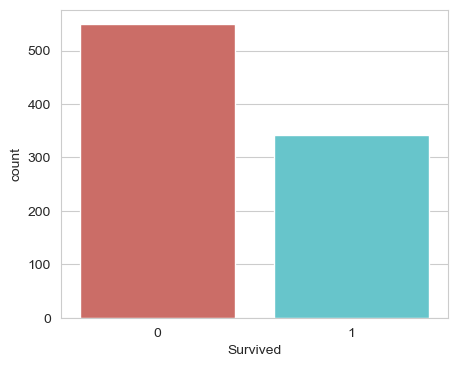

In [49]:
sb.countplot(x='Survived', data=titanic_training, palette='hls')
# binary variable, no choices other than 0 and 1, as desired/expected

### Checking for missing values

In [50]:
titanic_training.isnull().sum()
# checking the count of missing values, we are looking for specifically in 'survived'
# note that there are missing values in age, cabin, embarked as seen from .info() earlier

# if searching for zero values instead of null, we can do the following
# print((titanic_training[[1,2,3,4,5]] == 0).sum()) where the 1-5 are the column numbers (or names) that we are searching in

#OR we can convert them to null values. Be careful! Sometimes you might expect columns with 0 values that you wouldn't want to change!
# titanic_training[[1,2,3,4,5]] = titanic_training[[1,2,3,4,5]].replace(0, np.NaN)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [51]:
titanic_training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Taking care of missing values
##### Dropping missing values
So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:
- Survived - This variable is obviously relevant.
- Pclass - Does a passenger's class on the boat affect their survivability?
- Sex - Could a passenger's gender impact their survival rate?
- Age - Does a person's age impact their survival rate?
- SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability
- Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability
- Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
- Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.

What about a person's name, ticket number, and passenger ID number? They're irrelavant for predicting survivability. And as you recall, the cabin variable is almost all missing values, so we can just drop all of these.

In [52]:
# drop irrelevant values
titanic_data = titanic_training.drop(['Name', 'Ticket', 'Cabin'], axis=1)
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


### Imputing missing values

<Axes: xlabel='Parch', ylabel='Age'>

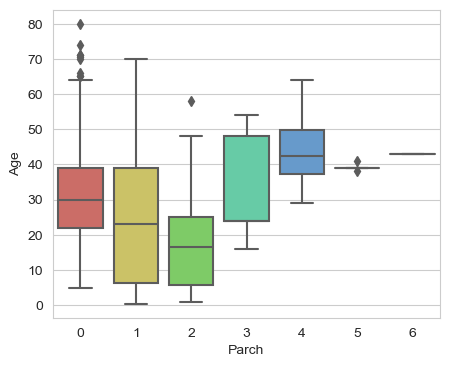

In [53]:
sb.boxplot(x='Parch', y='Age', data=titanic_data, palette='hls')
# parch represents number of relatives on the boat (parents, children, etc.)
# we can see younger the age, the more likely they are to have less people under parch

In [54]:
Parch_groups = titanic_data.groupby(titanic_data['Parch'])
Parch_groups.mean()
# finding mean age of each parch group

C:\Users\Admin\AppData\Local\Temp\ipykernel_18656\953914666.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Parch_groups.mean()


,PassengerId,Survived,Pclass,Age,SibSp,Fare
Parch,,,,,,
0,445.255162,0.343658,2.321534,32.178503,0.237463,25.586774
1,465.110169,0.550847,2.203390,24.422000,1.084746,46.778180
2,416.662500,0.500000,2.275000,17.216912,2.062500,64.337604
3,579.200000,0.600000,2.600000,33.200000,1.000000,25.951660
4,384.000000,0.000000,2.500000,44.500000,0.750000,84.968750
5,435.200000,0.200000,3.000000,39.200000,0.600000,32.550000
6,679.000000,0.000000,3.000000,43.000000,1.000000,46.900000


In [55]:
# using mean values to assign approximate age for each parch
def age_approx(cols):
    Age = cols[0]
    Parch = cols[1]
    
    if pd.isnull(Age):
        if Parch == 0:
            return 32
        elif Parch == 1:
            return 24
        elif Parch == 2:
            return 17
        elif Parch == 3:
            return 33
        elif Parch == 4:
            return 45
        else:
            return 30
        
    else:
        return Age

In [56]:
# now we can use the parch categories to assign age values to missing age passengers! 
# remember to find a category with correlation to use when filling missing values

# we could also use fillna with data.mean() as a less specific alternative (in applicable situations only)
titanic_data['Age']= titanic_data[['Age', 'Parch']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
dtype: int64

In [57]:
# embarked is less important (and is only 2 points), so we can drop it
# after dropping, reset the index to match the new record indexes
titanic_data.dropna(inplace=True)
titanic_data.reset_index(inplace=True, drop=True)

print(titanic_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Sex          889 non-null    object 
 4   Age          889 non-null    float64
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Fare         889 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.6+ KB
None


### Converting categorical variables to a dummy indicators

In [58]:
# we want to change gender/sex into a numeric value to be more easily analyzed
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
gender_cat = titanic_data["Sex"]
gender_encoded = label_encoder.fit_transform(gender_cat)
gender_encoded[0:5]
# this fits our 'male','female' values into 1's and 0's to be analyzed

array([1, 0, 0, 0, 1])

In [59]:
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [60]:
# 1 = male, 0 = female from looking at .head()
gender_df = pd.DataFrame(gender_encoded, columns=['male_gender'])
gender_df.head()

,male_gender
0,1
1,0
2,0
3,0
4,1


In [61]:
# similarly, we need to encode 'embarked' into a numeric category value
embarked_cat = titanic_data['Embarked']
embarked_encoded = label_encoder.fit_transform(embarked_cat)
print(embarked_encoded[0:100])
# this category used to be represented by 3 letters (S,C,Q)
# since there are 3 values, this is multinomial! We want to change it to binary values

[2 0 2 2 2 1 2 2 2 0 2 2 2 2 2 2 1 2 2 0 2 2 1 2 2 2 0 2 1 2 0 0 1 2 0 2 0
 2 2 0 2 2 0 0 1 2 1 1 0 2 2 2 0 2 0 2 2 0 2 2 0 2 2 0 0 2 2 2 2 2 2 2 0 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2]


In [62]:
from sklearn.preprocessing import OneHotEncoder
# this is a BINARY encoder
binary_encoder = OneHotEncoder(categories='auto')
embarked_1hot = binary_encoder.fit_transform(embarked_encoded.reshape(-1,1))
embarked_1hot_mat = embarked_1hot.toarray()
embarked_df = pd.DataFrame(embarked_1hot_mat, columns=['C', 'Q', 'S'])
embarked_df.head()
# this shows where the passengers embarked using binary values

,C,Q,S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [63]:
# now we don't need the sex or embarked in the original titanic dataframe, as we've made them all binary values.
titanic_data.drop(['Sex','Embarked'], axis=1, inplace=True)
titanic_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [64]:
# let's make a new df now with the binarized values added onto the old titanic df
titanic_dummy = pd.concat([titanic_data, gender_df, embarked_df], axis=1, verify_integrity=True).astype(float)
titanic_dummy.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male_gender,C,Q,S
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500,1.0,0.0,0.0,1.0
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,1.0,0.0,0.0
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,0.0,1.0
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,1.0
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500,1.0,0.0,0.0,1.0


### Checking for independence between features

<Axes: >

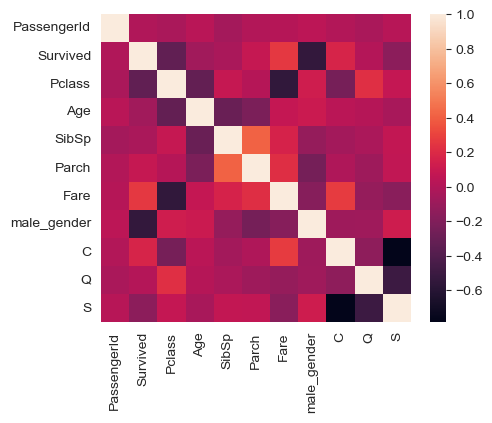

In [65]:
# let's take a look at correlation between variables using sb heatmap
sb.heatmap(titanic_dummy.corr())

# correlation close to +1 or -1 means strong correlation between variables
# variables need to be independent of each other to not violate linear regression assumptions


In [78]:
# we can tell that fare and Pclass are strongly related, so we should drop them
titanic_dummy.drop(['Fare', 'Pclass'], axis=1, inplace=True)
titanic_dummy.head()

,PassengerId,Survived,Age,SibSp,Parch,male_gender,C,Q,S
0,1.0,0.0,22.0,1.0,0.0,1.0,0.0,0.0,1.0
1,2.0,1.0,38.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3.0,1.0,26.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.0,1.0,35.0,1.0,0.0,0.0,0.0,0.0,1.0
4,5.0,0.0,35.0,0.0,0.0,1.0,0.0,0.0,1.0


### Checking that your dataset size is sufficient

In [79]:
# we should have at least 50 records per predictive feature
# in this dataset, we have 6 predictors (survived is what we're looking for, CQS are all one predictor together)
# therefore we need 6 * 50 = 300 datapoints 
titanic_dummy.info()
# clearly we have enough data to do a logreg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    float64
 1   Survived     889 non-null    float64
 2   Age          889 non-null    float64
 3   SibSp        889 non-null    float64
 4   Parch        889 non-null    float64
 5   male_gender  889 non-null    float64
 6   C            889 non-null    float64
 7   Q            889 non-null    float64
 8   S            889 non-null    float64
dtypes: float64(9)
memory usage: 62.6 KB


In [80]:
X_train, X_test, y_train, y_test = train_test_split(titanic_dummy.drop('Survived', axis=1), titanic_dummy['Survived'], test_size=0.2, random_state=200)
# split with X as columns other than 'survived', y as 'survived'
# with a 80/20 split of training and test data

In [81]:
print(X_train.shape, y_train.shape)

(711, 8) (711,)


In [82]:
X_train.head()

,PassengerId,Age,SibSp,Parch,male_gender,C,Q,S
719,721.0,6.0,0.0,1.0,0.0,0.0,0.0,1.0
165,167.0,24.0,0.0,1.0,0.0,0.0,0.0,1.0
879,882.0,33.0,0.0,0.0,1.0,0.0,0.0,1.0
451,453.0,30.0,0.0,0.0,1.0,1.0,0.0,0.0
181,183.0,9.0,4.0,2.0,1.0,0.0,0.0,1.0


### Deploying and evaluating the model

In [83]:
logReg = LogisticRegression(solver='liblinear')
logReg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [84]:
y_pred = logReg.predict(X_test)

## Model Evaluation
### Classification report without cross-validation

In [85]:
# let's see how well the prediction did!
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85       109
         1.0       0.79      0.71      0.75        69

    accuracy                           0.81       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178



### K-fold cross-validation & confusion matrices

In [86]:
# let's try it again with kfold cross and see how it can change (we're using 5 folds for now)
y_train_pred = cross_val_predict(logReg, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)
# 377, 180 correct (TN, TP)
# 91, 63 incorrect (FP, FN)

array([[377,  63],
       [ 91, 180]], dtype=int64)

In [87]:
precision_score(y_train, y_train_pred)

0.7407407407407407

### Make a test prediction

In [88]:
# let's make a fake passenger and see how the prediction works
# this is an example real passenger:
titanic_dummy[863:864]

,PassengerId,Survived,Age,SibSp,Parch,male_gender,C,Q,S
863,866.0,1.0,42.0,0.0,0.0,0.0,0.0,0.0,1.0


In [89]:
# don't include survived, as that's what we're trying to predict
# same as the other passenger, but just 2 years younger
test_passenger = np.array([866, 40, 0, 0, 0, 0, 0, 1]).reshape(1,-1)

print(logReg.predict(test_passenger))
print(logReg.predict_proba(test_passenger))

# this passenger is predcited to survive, which makes sense as he is almost identical to passenger 866
# the chance of this being correct is 73%!

[1.]
[[0.26351831 0.73648169]]


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Hyperparameter Tuning

In [92]:
# initiate LR model with random hyperparameters
hyperLR = LogisticRegression(penalty='l1', dual=False, max_iter=110, solver='liblinear')
# penalty used to specify the norm used in the penalization
# dual formulation
# maxc iterations to converge

# fit training data
hyperLR.fit(X_train, y_train)

LogisticRegression(max_iter=110, penalty='l1', solver='liblinear')

In [106]:
# test the results
print(hyperLR.score(X_test,y_test))

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# again, but with k fold cross val
kfold = KFold(n_splits=3, random_state=7, shuffle=True)

result = cross_val_score(hyperLR, X_test, y_test, cv=kfold, scoring='accuracy')
print(result.mean())

# slightly lower as a mean

0.8146067415730337
0.8031073446327683


In [108]:
# first with grid search tuning
from sklearn.model_selection import GridSearchCV

# defining grid values for the hyperparameters
dual=[True,False]
max_iter = [100,110,120,130,140]
param_grid = dict(dual=dual, max_iter=max_iter)



In [114]:
# let's try doing the regression again with a grid search and keeping track of time
import time

lr = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator=hyperLR, param_grid=param_grid, cv=3, n_jobs=-1)

start_time = time.time()
grid_result = grid.fit(X_test, y_test)

# summarize results
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')


Best: 0.791996 using {'dual': False, 'max_iter': 100}
Execution time: 0.03693079948425293 ms


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1216, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solve

In [113]:
# trying again with random search 
from sklearn.model_selection import RandomizedSearchCV

random = RandomizedSearchCV(estimator=hyperLR, param_distributions=param_grid, cv=3, n_jobs=-1)
start_time = time.time()
random_result = random.fit(X_test, y_test)

# summarize results
print("Best: %f using %s" %(random_result.best_score_, random_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')


Best: 0.791996 using {'max_iter': 100, 'dual': False}
Execution time: 0.03593730926513672 ms


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1216, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solve